In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
run /content/drive/MyDrive/accidents/EDA.ipynb

In [2]:
# pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score, r2_score
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

from collections import Counter

import shap

In [ ]:
# #uploading the dataset
# new_df = pd.read_csv('../data/new_df.csv')

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3859011 entries, 728 to 7728393
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Severity               int64         
 1   Start_Time             datetime64[ns]
 2   End_Time               datetime64[ns]
 3   Start_Lat              float64       
 4   Start_Lng              float64       
 5   Distance(mi)           float64       
 6   Description            object        
 7   Street                 object        
 8   City                   object        
 9   County                 object        
 10  State                  object        
 11  Zipcode                object        
 12  Weather_Timestamp      datetime64[ns]
 13  Temperature(F)         float64       
 14  Wind_Chill(F)          float64       
 15  Humidity(%)            float64       
 16  Pressure(in)           float64       
 17  Visibility(mi)         float64       
 18  Wind_Speed(mph)     

In [ ]:
#seeing if we have class imbalanced
new_df['Severity'].value_counts()

0    3214835
1     644176
Name: Severity, dtype: int64

In [ ]:
#defining the predictor/target variables
X = new_df.drop(columns=['Severity', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Weather_Condition',
                        'Weather_Timestamp', 'Start_Time', 'End_Time'], axis=1)
y = new_df['Severity']

In [ ]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=88)

In [ ]:
X_train.shape

(2894258, 27)

In [ ]:
X_test.shape

(964753, 27)

In [ ]:
y_train.shape

(2894258,)

In [ ]:
y_test.shape

(964753,)

# Resampling with SMOTE

### Logistic Regression with SMOTE

In [ ]:
smote = SMOTE(random_state=88)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

ss = StandardScaler()

ss.fit(X_train_resampled)

X_train_scaled = ss.transform(X_train_resampled)
X_test_scaled = ss.transform(X_test)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_resampled))

Original dataset shape Counter({0: 2411118, 1: 483140})
Resample dataset shape Counter({1: 2411118, 0: 2411118})


In [ ]:
logreg = LogisticRegression() #multi_class='multinomial')

In [ ]:
logreg.fit(X_train_scaled, y_train_resampled)

LogisticRegression()

In [ ]:
y_pred = logreg.predict(X_test_scaled)

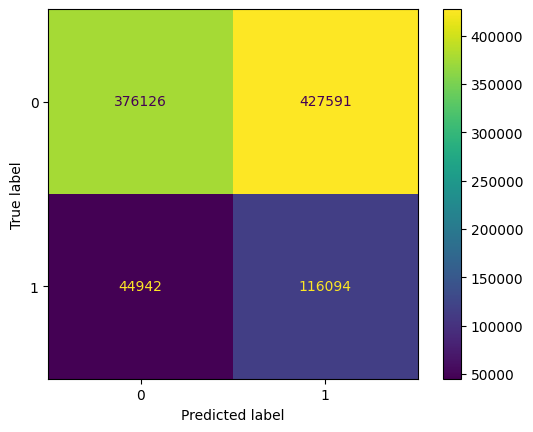

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test);

In [ ]:
(116089+376132)/(116089+376132+427585+44947)

0.5102041662477339

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.5102031297129939

In [ ]:
metrics.recall_score(y_test, y_pred)

0.7209195459400383

In [ ]:
metrics.precision_score(y_test, y_pred)

0.213531732528946

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.47      0.61    803717
           1       0.21      0.72      0.33    161036

    accuracy                           0.51    964753
   macro avg       0.55      0.59      0.47    964753
weighted avg       0.78      0.51      0.57    964753



### Random Forest with SMOTE

In [ ]:
rf = RandomForestClassifier(random_state=88)

In [ ]:
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=88)

In [ ]:
y_pred = rf.predict(X_test)

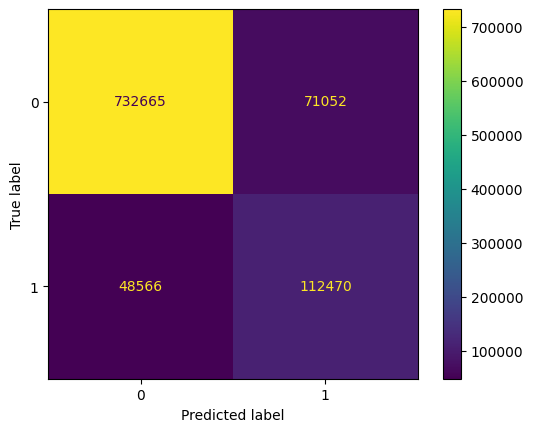

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test);

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.8760117874730631

In [ ]:
metrics.recall_score(y_test, y_pred)

0.6984152611838347

In [ ]:
metrics.precision_score(y_test, y_pred)

0.6128420570830745

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92    803717
           1       0.61      0.70      0.65    161036

    accuracy                           0.88    964753
   macro avg       0.78      0.81      0.79    964753
weighted avg       0.88      0.88      0.88    964753



### Random Forest: Feature Importances

In [ ]:
feature = X.columns.tolist()
pd.DataFrame({'feature': feature,
              'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,Start_Lng,0.156385
0,Start_Lat,0.147460
2,Distance(mi),0.145527
9,Precipitation(in),0.117215
6,Pressure(in),0.094296
5,Humidity(%),0.068135
4,Wind_Chill(F),0.061770
3,Temperature(F),0.058955
21,Traffic_Signal,0.034171
12,Crossing,0.027787


# Resampling with NearMiss

### Logistic Regression with NearMiss

In [ ]:
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)

ss = StandardScaler()

ss.fit(X_res)

X_train_scaled = ss.transform(X_res)
X_test_scaled = ss.transform(X_test)

print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 3214835, 1: 644176})
Resampled dataset shape Counter({0: 483140, 1: 483140})


In [ ]:
logreg2 = LogisticRegression(multi_class='multinomial')

In [ ]:
logreg2.fit(X_train_scaled, y_res)

LogisticRegression(multi_class='multinomial')

In [ ]:
y_pred = logreg2.predict(X_test_scaled)

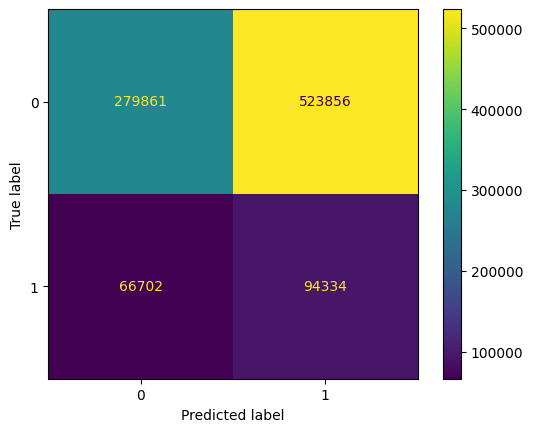

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg2, X_test_scaled, y_test);

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.3878661170268452

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.35      0.49    803717
           1       0.15      0.59      0.24    161036

    accuracy                           0.39    964753
   macro avg       0.48      0.47      0.36    964753
weighted avg       0.70      0.39      0.45    964753



### Random Forest with NearMiss

In [ ]:
rf_nearmiss = RandomForestClassifier(random_state=88)

In [ ]:
rf_nearmiss.fit(X_res, y_res)

RandomForestClassifier(random_state=88)

In [ ]:
y_pred = rf_nearmiss.predict(X_test)

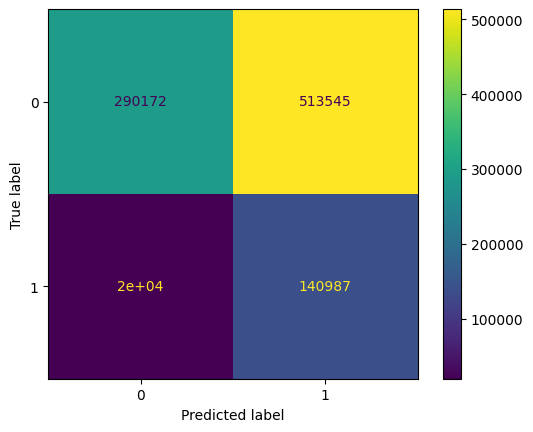

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf_nearmiss, X_test, y_test);

In [ ]:
metrics.accuracy_score(y_test, y_pred)

0.44691128195507035

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.36      0.52    803717
           1       0.22      0.88      0.35    161036

    accuracy                           0.45    964753
   macro avg       0.58      0.62      0.43    964753
weighted avg       0.82      0.45      0.49    964753



### Random Forest: Feature Importances

In [ ]:
feature = X.columns.tolist()
pd.DataFrame({'feature': feature,
              'importance': rf_nearmiss.feature_importances_}).sort_values(by='importance', ascending=False)

,feature,importance
1,Start_Lng,0.198433
0,Start_Lat,0.195587
2,Distance(mi),0.157610
6,Pressure(in),0.089615
5,Humidity(%),0.084358
3,Temperature(F),0.079748
4,Wind_Chill(F),0.056862
9,Precipitation(in),0.035635
7,Visibility(mi),0.033531
23,Sunset,0.016694


NearMiss is ineffective in addressing class imbalance. The accuracy scores for both Logistic Regression and Random Forest were less than 50% compared with SMOTE with accuracy scores above 50%. Thus, I will be using SMOTE for subsequent models.

# Tuning Hyperparameters with GridSearchCV

In [ ]:
counter = Counter(y)
print(counter)

Counter({0: 3214835, 1: 644176})


In [ ]:
pipe = Pipeline([('random_forest', RandomForestClassifier(random_state=88))])

params = {'random_forest__n_estimators': np.arange(20,100,40),
          'random_forest__criterion':['entropy'],
          'random_forest__max_depth': np.arange(8,12,2)}
          # 'random_forest__max_features': np.arange(18,30,4)}

grid = GridSearchCV(pipe, param_grid=params, cv=5)
grid.fit(X_train_resampled, y_train_resampled)

In [ ]:
best_est = grid.best_estimator_
best_est